# Human action recognition

In this jupyter notebook we will perform classification on Human Action Recognition dataset from kaggle: https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset

The dataset consists of around 12 thousand images labelled into 15 categories of human activities such as:
* calling 
* clapping
* cycling
* dancing
* drinking
* eating
* fighting
* hugging
* laughing
* listening_to_music
* running
* sitting
* sleeping
* texting
* using_laptop

To classify our images we will be using models mentioned below:
* K-Nearest Neighbors
* Neural Network
* Convolutional Neural Network

... and for comparison we will train a feature extractor model on our data to see how our models compare to the results of a larger model.

Our objective in this classification project will be to reach **85%** of accuracy.

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-17 08:22:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-17 08:22:01 (129 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import make_confusion_matrix

## Data preparation

First we will download the data and unzip it to check the folder structure

In [ ]:
!wget https://dphi-live.s3.eu-west-1.amazonaws.com/dataset/Human+Action+Recognition-20220526T101201Z-001.zip

--2023-05-10 19:33:30--  https://dphi-live.s3.eu-west-1.amazonaws.com/dataset/Human+Action+Recognition-20220526T101201Z-001.zip
Resolving dphi-live.s3.eu-west-1.amazonaws.com (dphi-live.s3.eu-west-1.amazonaws.com)... 52.218.108.136, 52.92.32.66, 52.218.25.232, ...
Connecting to dphi-live.s3.eu-west-1.amazonaws.com (dphi-live.s3.eu-west-1.amazonaws.com)|52.218.108.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332937529 (318M) [application/zip]
Saving to: ‘Human+Action+Recognition-20220526T101201Z-001.zip’

Human+Action+Recogn 100%[===================>] 317.51M  6.53MB/s    in 29s     

2023-05-10 19:33:59 (11.1 MB/s) - ‘Human+Action+Recognition-20220526T101201Z-001.zip’ saved [332937529/332937529]



In [ ]:
zip_ref = zipfile.ZipFile("/content/Human+Action+Recognition-20220526T101201Z-001.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
train_df = pd.read_csv("/content/Human Action Recognition/Training_set.csv")
test_df = pd.read_csv("/content/Human Action Recognition/Testing_set.csv")

In [ ]:
np.unique(train_df["label"]), len(np.unique(train_df["label"]))

(array(['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating',
        'fighting', 'hugging', 'laughing', 'listening_to_music', 'running',
        'sitting', 'sleeping', 'texting', 'using_laptop'], dtype=object),
 15)

In [ ]:
class_names = np.unique(train_df["label"])

All of the images are stored in one folder, but we have a csv file that contains labels of these images.
Since we don't have that many images (~12 000) we will sort them into folders corresponding to their labels.

In [ ]:
!mkdir data
!cd data && mkdir test
!cd data && mkdir train

In [ ]:
for classname in class_names:
  os.makedirs(os.path.join("data", "test", classname))
  os.makedirs(os.path.join("data", "train", classname))

In [ ]:
for index, row in train_df.iterrows():
  filename = row[0]
  classname = row[1]
  
  !mv "/content/Human Action Recognition/train/{filename}" "/content/data/train/{classname}/{filename}"

Let's zip the training folder with our images for further usage.

In [ ]:
def zipdir(path, ziph):
  # ziph is zipfile handle
  for root, dirs, files in os.walk(path):
    for file in files:
      ziph.write(os.path.join(root, file), 
                 os.path.relpath(os.path.join(root, file), 
                                 os.path.join(path, '..')))

with zipfile.ZipFile('data.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
  zipdir('/content/data/train', zipf)

In [ ]:
!cd /content/drive/MyDrive/ && mkdir HAR
!cp /content/data.zip /content/drive/MyDrive/HAR/data.zip

In [ ]:
!mkdir HAR_data

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/HAR/data.zip")
zip_ref.extractall()
zip_ref.close()

Now, that we have our images separated into folders corresponding to their labels we can use `image_dataset_from_directory` function from tensorflow to read in the data and split it into training and validation set.

I have decided to use the batch size of 64 to gain optimal results of our model and in order not to cause overfitting or underfitting (<a href="https://blog.paperspace.com/how-to-maximize-gpu-utilization-by-finding-the-right-batch-size/">source</a>) and also this batch size is optimal to fit in the memory of the GPU we are using (Nvidia T4).

We will rescale our images to 224x224 size which will be enough to get decent results without losing to much informaion from the images. We also want to keep the aspect ratio while cropping since most of the action in the pictures takes place in the middle and any stretch or squeeze of the information in the image may lead to inaccurate results.

We will also use 10% of the data as validation data (this insignificant amount of validation data results from small amount of data overall). 

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds, val_ds = image_dataset_from_directory(directory="/content/train",
                                                label_mode="int",
                                                batch_size=64,
                                                image_size=(224, 224),
                                                validation_split=0.1,
                                                subset="both",
                                                seed=42,
                                                shuffle=True,
                                                crop_to_aspect_ratio=True)

Found 12600 files belonging to 15 classes.
Using 11340 files for training.
Using 1260 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

### Data augumentation

To further prevent overfitting and learn model to generalize better we will augument the data slightly. We will use a Sequential layer with layers such as; Rescaling, which will normalize our images, RandomZoom to zoom in a bit, RandomFlip to randomly flip the images across horizontal axis, RandomContrast to introduce some variance in the images and RandomRotation to add further augumentation.

In [ ]:
from tensorflow.keras.layers import (RandomZoom, 
                                     RandomCrop, 
                                     RandomBrightness, 
                                     RandomContrast, 
                                     RandomFlip, 
                                     Rescaling, 
                                     RandomRotation)

data_augumentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomZoom(0.2),
    RandomFlip(mode="horizontal"),
    RandomContrast(0.2),
    RandomRotation(0.1)
])

### Visualizing our data
Let's visualize some of the non-augumented images.

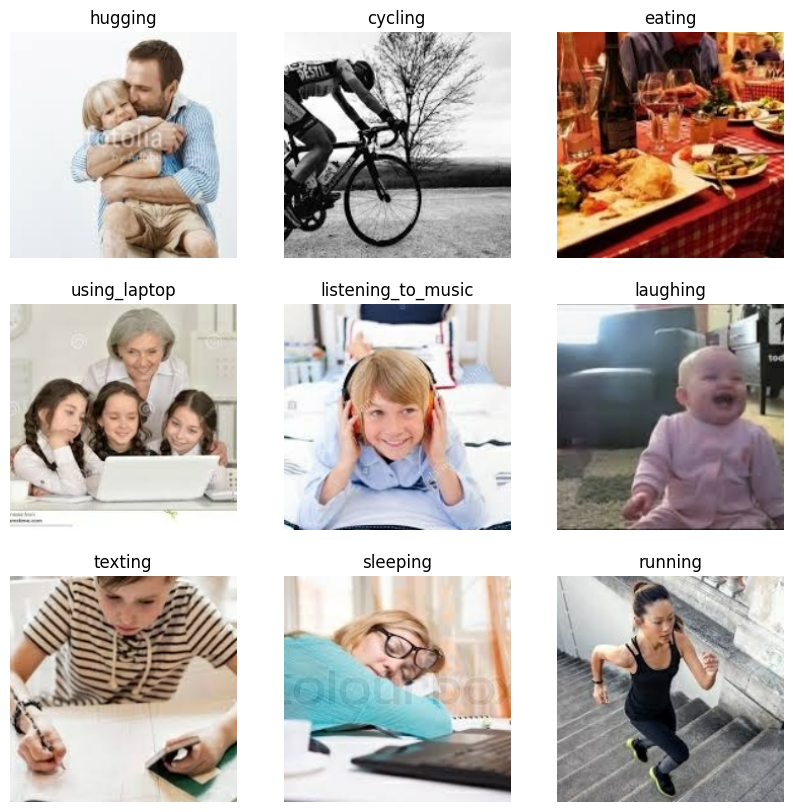

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = labels[i]
    plt.title(class_names[index])
    plt.axis("off")

Let's see how the data augumentation changes our images.

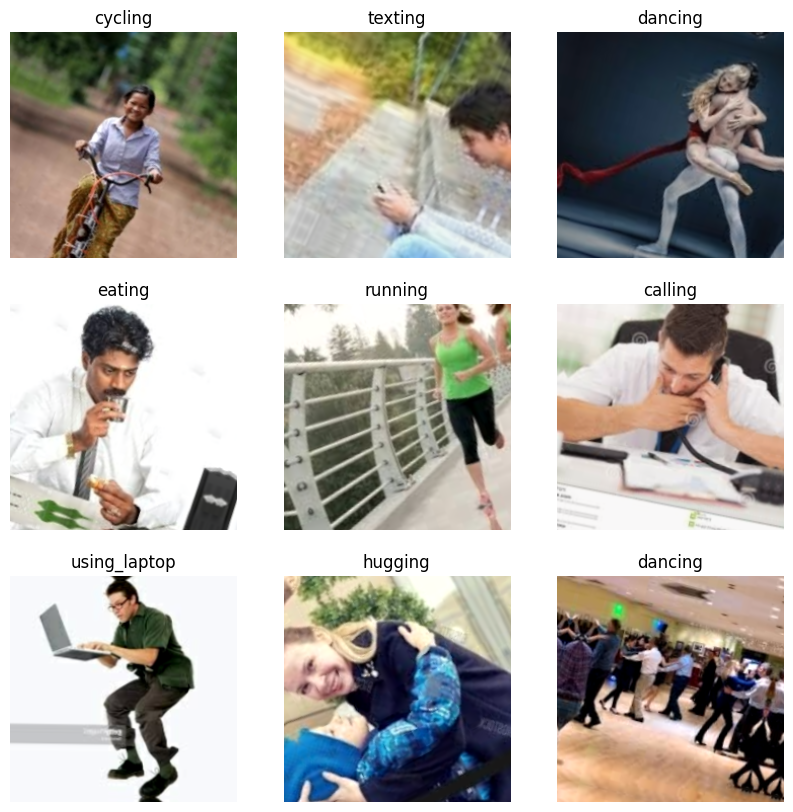

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augumentation(images[i]))
    index = labels[i]
    plt.title(class_names[index])
    plt.axis("off")

## Training our models

All of our models will be trained on whole dataset for no more than 200 epochs (iterations).

In our models I decided to use a LeakyReLU activation function.

According to *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow* by Aurélien Géron, ReLU activation function isn't perfect because of a thing called *dying ReLUs* which means that during training some of the neurons die and continuosly send zeros which results in some part of the neural network being dead.

To avoid this problem we use a LeakyReLU activation function which causes the *dying neurons* to fall in a coma and eventually there is a chance of waking them up.

Additionally to avoid the problem of exploding gradients I decided to use `kernel_initializer="he_normal"` in our hidden layers which actually suits our LeakyReLU activation function.

In [19]:
accuracy_results = {"knn": 0,
                    "knn_data_aug": 0,
                    "nn": 0,
                    "nn_data_aug": 0,
                    "cnn": 0,
                    "cnn_data_aug": 0,
                    "efficient_net_b0": 0}

### K-Nearest Neighbours

We will kick off the training with KNN model implemented in tensorflow. 

In order to train it we will have to convert our dataset into a dataframe.

While converting our data into dataframe we have to rescale images to 112x112 size, because storing 12 thousand images with shape 224x224x3 resulted in running out of memory each time.

In [ ]:
import cv2
from sklearn.model_selection import train_test_split

training_dir = "/content/train"

images = []
labels = []

for class_name in os.listdir(training_dir):
    class_dir = os.path.join(training_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):
                image_path = os.path.join(class_dir, filename)
                image = cv2.imread(image_path) 
                image = cv2.resize(image, (112, 112))
                images.append(image)
                labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

n_samples, height, width, channels = images.shape
images = images.reshape(n_samples, height * width * channels)

data = pd.DataFrame(images, columns=[f"pixel{i}" for i in range(height * width * channels)])
data["label"] = labels

label_mapping = {class_name: label for label, class_name in enumerate(data["label"].unique())}
data["label"] = data["label"].map(label_mapping)

X = data.drop("label", axis=1) / 255.
y = data["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11340, 37632), (1260, 37632), (11340,), (1260,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=11)

In [ ]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
knn_score = knn_model.score(X_val, y_val)
knn_score_train = knn_model.score(X_train, y_train)

In [ ]:
accuracy_results["knn"] = knn_score
knn_score, knn_score_train

(0.13015873015873017, 0.2837742504409171)

In [ ]:
knn_preds = knn_model.predict(X_val)

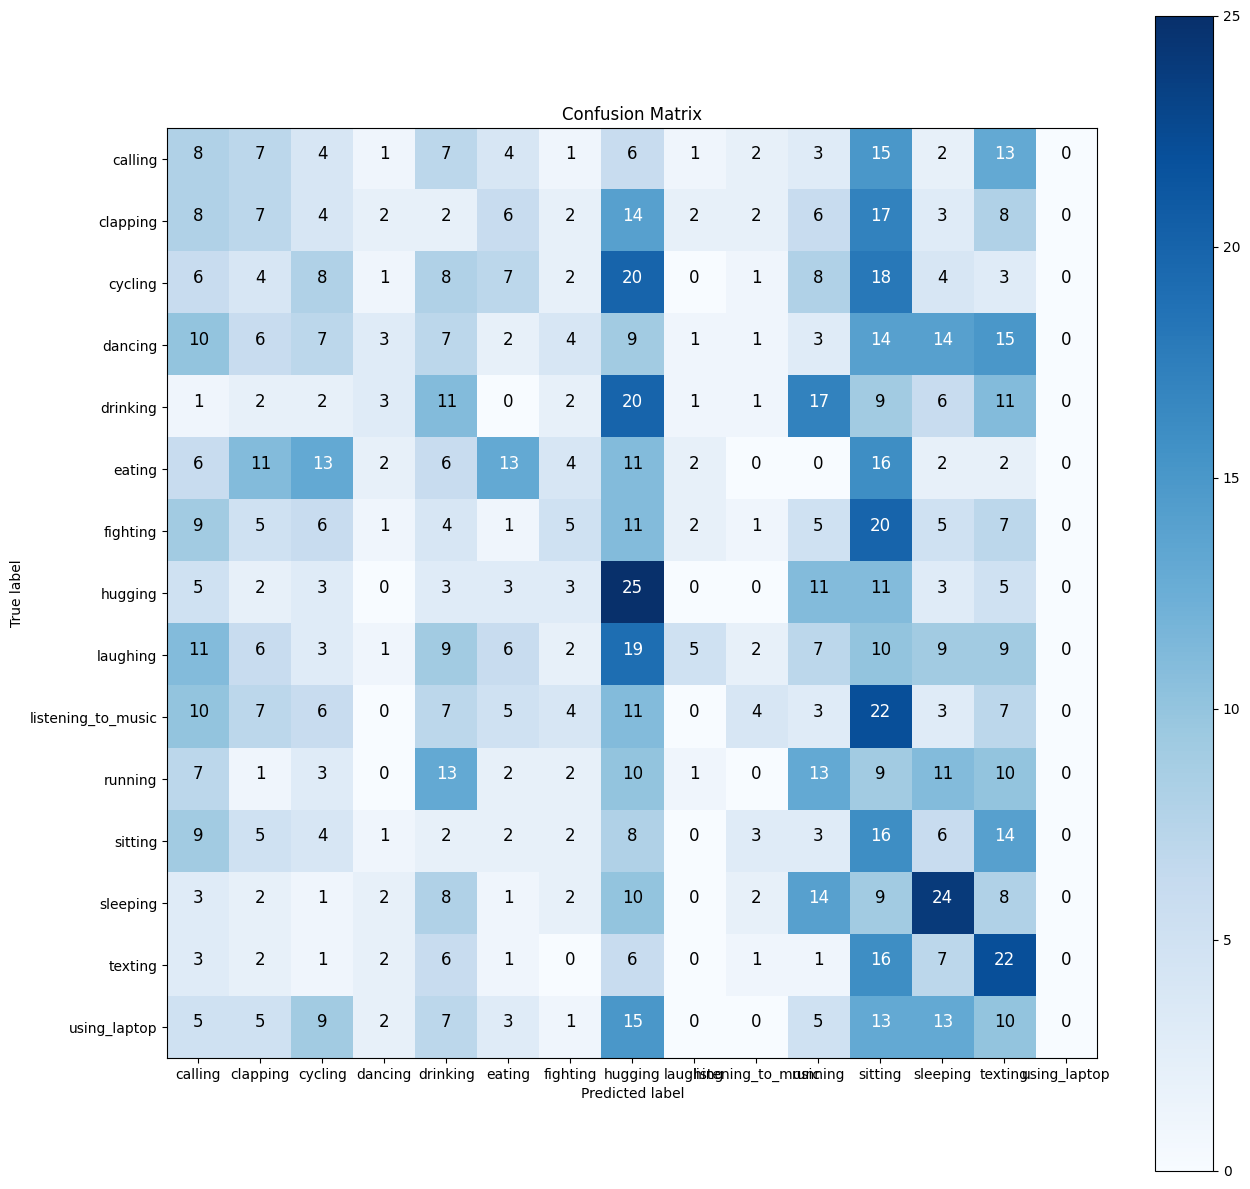

In [ ]:
make_confusion_matrix(y_true=y_val,
                      y_pred=knn_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

### K-Nearest Neighbours with data augumentation

In [ ]:
import cv2
from sklearn.model_selection import train_test_split

training_dir = "/content/train"

images = []
labels = []

for class_name in os.listdir(training_dir):
    class_dir = os.path.join(training_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):
                image_path = os.path.join(class_dir, filename)
                image = cv2.imread(image_path) 
                image = cv2.resize(image, (112, 112))
                images.append(data_augumentation(image))
                labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

n_samples, height, width, channels = images.shape
images = images.reshape(n_samples, height * width * channels)

data_aug = pd.DataFrame(images, columns=[f"pixel{i}" for i in range(height * width * channels)])
data_aug["label"] = labels

label_mapping = {class_name: label for label, class_name in enumerate(data_aug["label"].unique())}
data_aug["label"] = data_aug["label"].map(label_mapping)

X_aug = data_aug.drop("label", axis=1)
y_aug = data_aug["label"]

X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_aug, y_aug, test_size=0.1)

In [ ]:
knn_model_data_aug = KNeighborsClassifier(n_neighbors=11)

In [ ]:
knn_model_data_aug.fit(X_train_aug, y_train_aug)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
knn_data_aug_score = knn_model_data_aug.score(X_val, y_val)
knn_data_aug_train_score = knn_model_data_aug.score(X_train_aug, y_train_aug)

In [ ]:
accuracy_results["knn_data_aug"] = knn_data_aug_score
knn_data_aug_score, knn_data_aug_train_score

(0.16984126984126985, 0.2722222222222222)

In [ ]:
knn_data_aug_preds = knn_model_data_aug.predict(X_val)

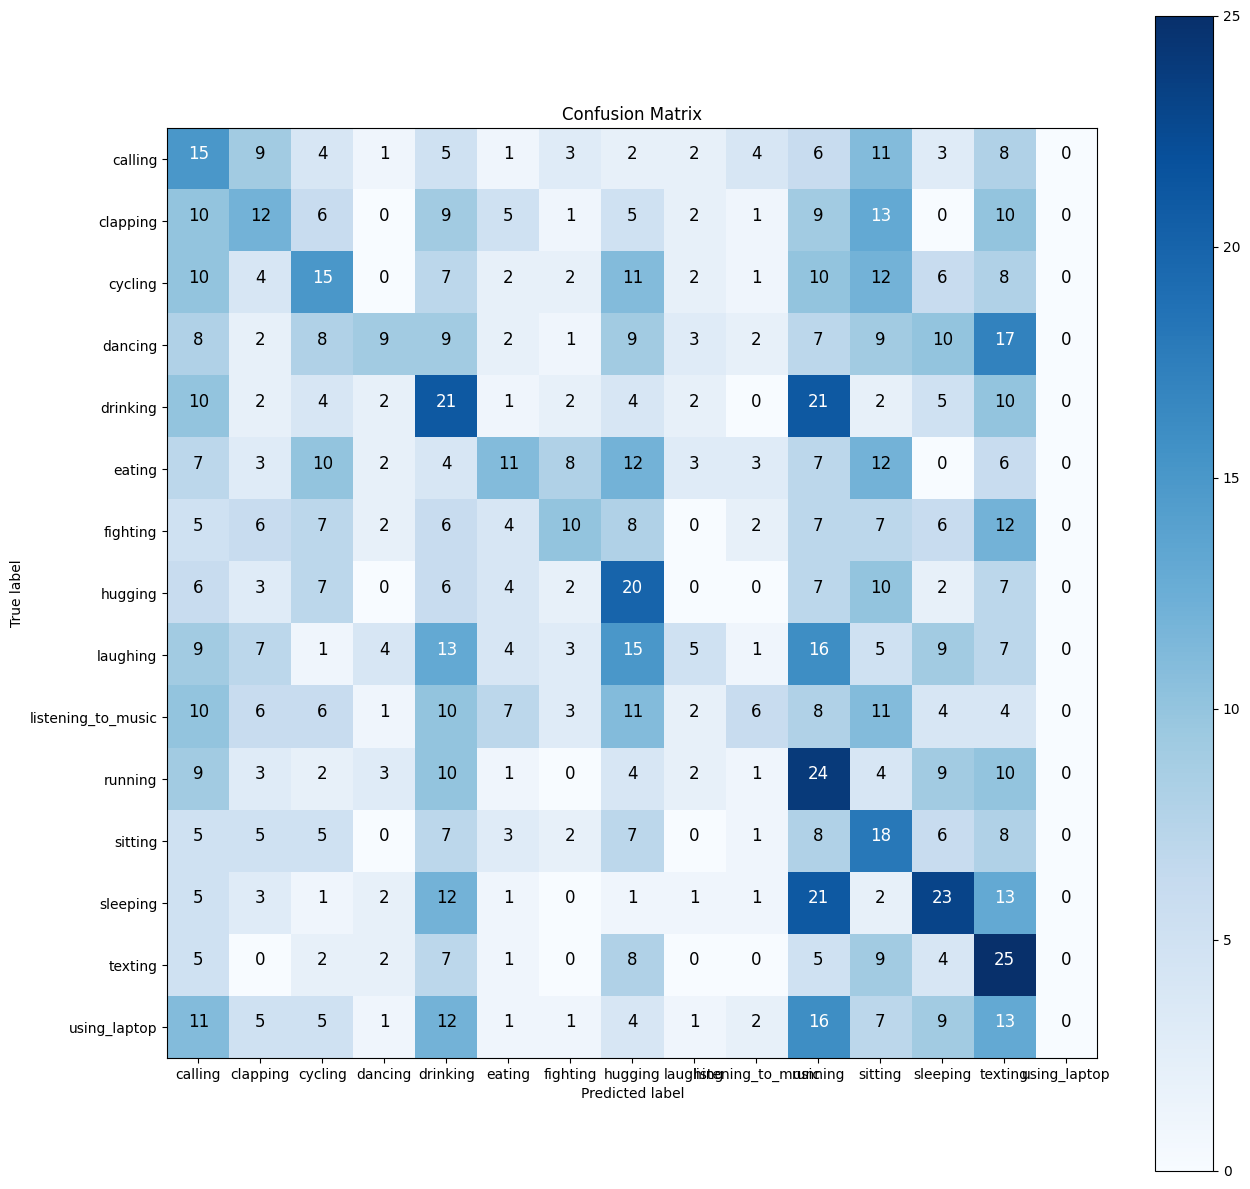

In [ ]:
make_confusion_matrix(y_true=y_val,
                      y_pred=knn_data_aug_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

### Neural Network
Next up we have a neural network with some hidden layers.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU, ELU, PReLU, ReLU

In [ ]:
input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(128, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(256, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(512, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation="softmax")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                metrics=["accuracy"])

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min', 
                                                  patience=5, 
                                                  restore_best_weights=True,
                                                  start_from_epoch=30)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/HAR/model_0_checkpoint",
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

history_0 = model_0.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                        epochs=100,
                        validation_data=val_ds,
                        validation_steps=len(val_ds),
                        callbacks=[early_stopping,
                                   checkpoint_callback])

Epoch 1/100
178/178 [==============================] - 17s 49ms/step - loss: 5418.4507 - accuracy: 0.0679 - val_loss: 104.9378 - val_accuracy: 0.0865
Epoch 2/100
178/178 [==============================] - 9s 52ms/step - loss: 424.2379 - accuracy: 0.0684 - val_loss: 68.0241 - val_accuracy: 0.0770
Epoch 3/100
178/178 [==============================] - 9s 48ms/step - loss: 253.1675 - accuracy: 0.0725 - val_loss: 48.5750 - val_accuracy: 0.0714
Epoch 4/100
178/178 [==============================] - 8s 45ms/step - loss: 177.1995 - accuracy: 0.0682 - val_loss: 44.3586 - val_accuracy: 0.0889
Epoch 5/100
178/178 [==============================] - 9s 47ms/step - loss: 145.3011 - accuracy: 0.0692 - val_loss: 39.4182 - val_accuracy: 0.0706
Epoch 6/100
178/178 [==============================] - 9s 49ms/step - loss: 165.0363 - accuracy: 0.0715 - val_loss: 42.6485 - val_accuracy: 0.0698
Epoch 7/100
178/178 [==============================] - 8s 42ms/step - loss: 131.9715 - accuracy: 0.0663 - val_loss:

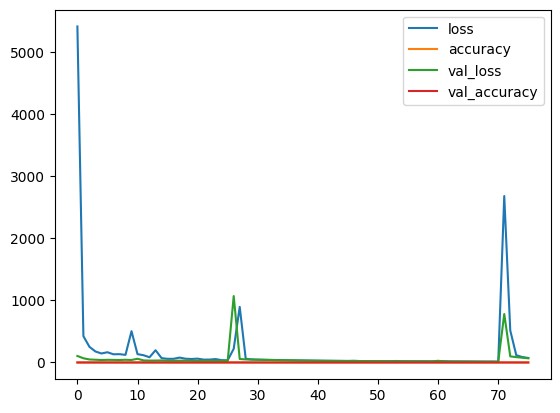

In [ ]:
# Plot loss curve
pd.DataFrame(history_0.history).plot()
plt.legend();

In [ ]:
# Evaluate the model on weights from the last epoch
model_0.evaluate(val_ds)

20/20 [==============================] - 1s 48ms/step - loss: 12.2461 - accuracy: 0.0841


[12.246143341064453, 0.08412698656320572]

In [ ]:
# Load the best weights from checkpoint
model_0.load_weights("/content/drive/MyDrive/HAR/model_0_checkpoint")

In [ ]:
# Evaluate the model on loaded weights
nn_accuracy = model_0.evaluate(val_ds)

20/20 [==============================] - 1s 36ms/step - loss: 36.8843 - accuracy: 0.1198


In [20]:
accuracy_results["nn"] = nn_accuracy[1]

In [21]:
nn_preds = model_0.predict(val_ds)
nn_preds = tf.argmax(nn_preds, axis=1)
nn_preds

20/20 [==============================] - 2s 80ms/step


<tf.Tensor: shape=(1260,), dtype=int64, numpy=array([14,  2,  2, ...,  2,  6, 13])>

In [22]:
labels = np.concatenate([y for x, y in val_ds], axis=0)
labels

array([8, 3, 5, ..., 6, 1, 8], dtype=int32)

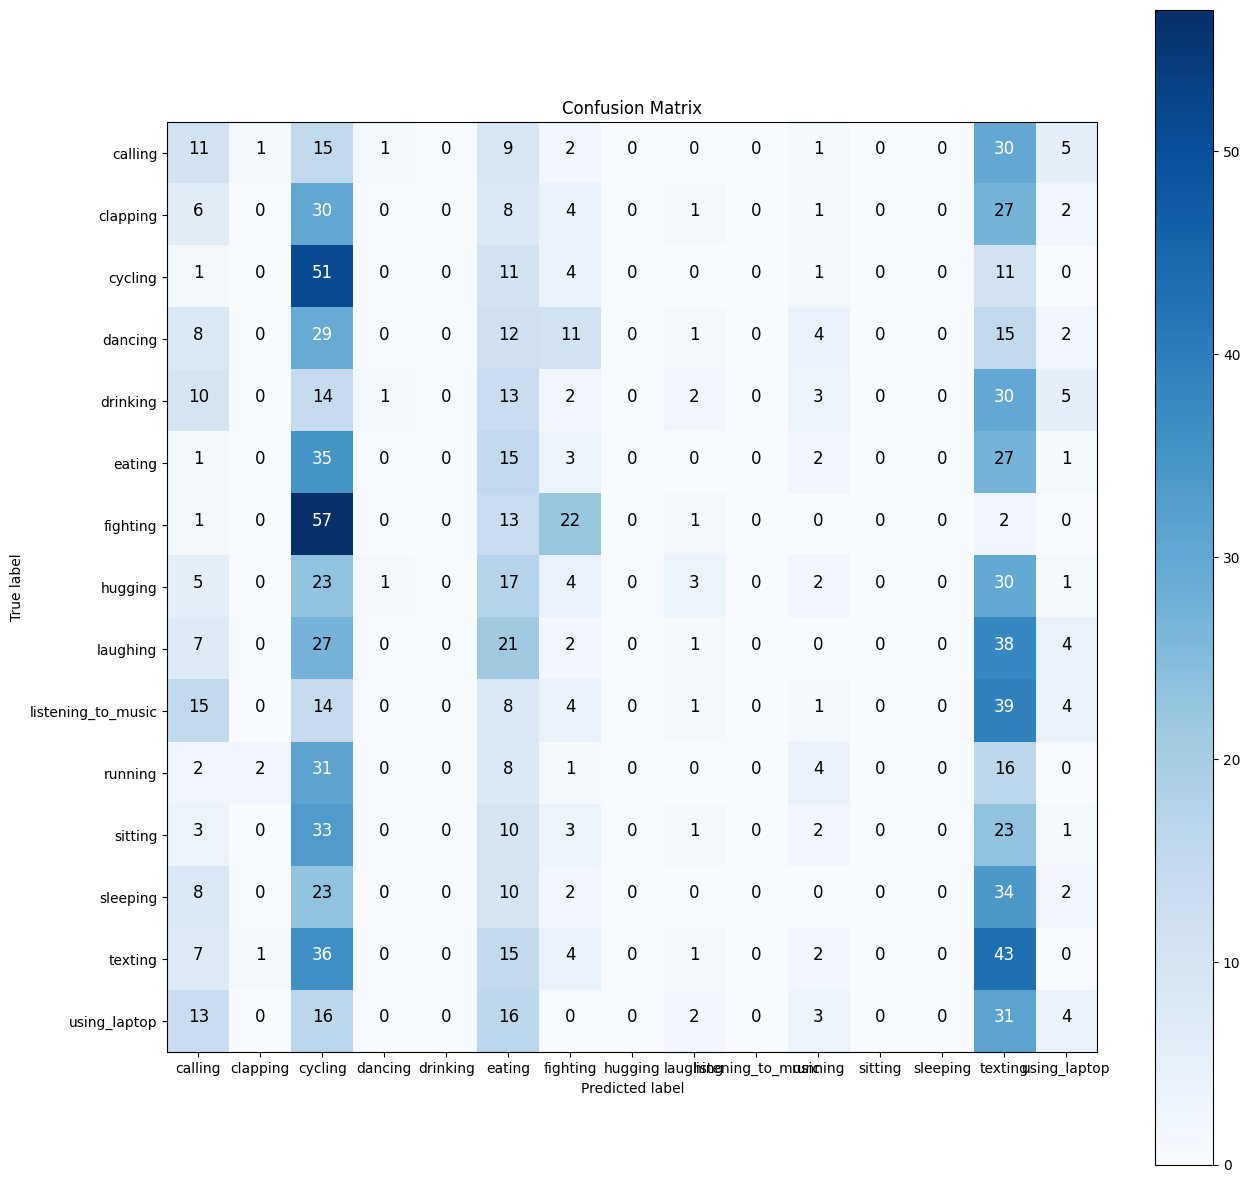

In [26]:
make_confusion_matrix(y_true=labels,
                      y_pred=nn_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

### Neural network with data augumentation

In [27]:
input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)
x = data_augumentation(inputs)
x = Flatten()(x)
x = Dense(128, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(256, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(512, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, 
          activation="leaky_relu",
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation="softmax")(x)

model_0_data_aug = tf.keras.Model(inputs, outputs)

model_0_data_aug.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=["accuracy"])

In [28]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min', 
                                                  patience=5, 
                                                  restore_best_weights=True,
                                                  start_from_epoch=30)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/HAR/model_0_data_aug_checkpoint",
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

history_0_data_aug = model_0_data_aug.fit(train_ds,
                                          steps_per_epoch=len(train_ds),
                                          epochs=100,
                                          validation_data=val_ds,
                                          validation_steps=len(val_ds),
                                          callbacks=[early_stopping,
                                                      checkpoint_callback])

Epoch 1/100
178/178 [==============================] - 13s 50ms/step - loss: 47.5163 - accuracy: 0.0714 - val_loss: 26.4348 - val_accuracy: 0.0825
Epoch 2/100
178/178 [==============================] - 9s 49ms/step - loss: 25.5052 - accuracy: 0.0671 - val_loss: 23.9081 - val_accuracy: 0.0754
Epoch 3/100
178/178 [==============================] - 9s 50ms/step - loss: 23.1756 - accuracy: 0.0643 - val_loss: 21.9616 - val_accuracy: 0.0714
Epoch 4/100
178/178 [==============================] - 14s 74ms/step - loss: 21.2149 - accuracy: 0.0733 - val_loss: 20.2014 - val_accuracy: 0.0675
Epoch 5/100
178/178 [==============================] - 13s 70ms/step - loss: 19.4005 - accuracy: 0.0693 - val_loss: 18.4414 - val_accuracy: 0.0905
Epoch 6/100
178/178 [==============================] - 8s 42ms/step - loss: 17.6698 - accuracy: 0.0737 - val_loss: 16.7805 - val_accuracy: 0.0905
Epoch 7/100
178/178 [==============================] - 10s 54ms/step - loss: 16.0812 - accuracy: 0.0737 - val_loss: 15.24

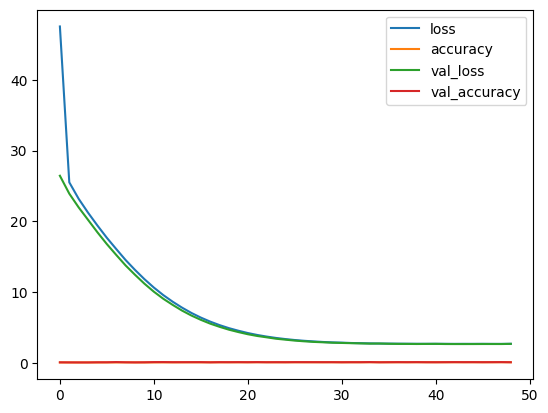

In [30]:
# Plot loss curve
pd.DataFrame(history_0_data_aug.history).plot()
plt.legend();

In [31]:
# Evaluate the model on weights from the last epoch
model_0_data_aug.evaluate(val_ds)

20/20 [==============================] - 1s 42ms/step - loss: 2.6655 - accuracy: 0.1087


[2.6655399799346924, 0.10873015969991684]

In [32]:
# Load the best weights from checkpoint
model_0_data_aug.load_weights("/content/drive/MyDrive/HAR/model_0_data_aug_checkpoint")

In [33]:
# Evaluate the model on loaded weights
nn_data_aug_accuracy = model_0_data_aug.evaluate(val_ds)

20/20 [==============================] - 1s 49ms/step - loss: 15.2488 - accuracy: 0.1222


In [34]:
accuracy_results["nn_data_aug"] = nn_data_aug_accuracy[1]

In [35]:
nn_data_aug_preds = model_0_data_aug.predict(val_ds)
nn_data_aug_preds = tf.argmax(nn_data_aug_preds, axis=1)

20/20 [==============================] - 1s 48ms/step


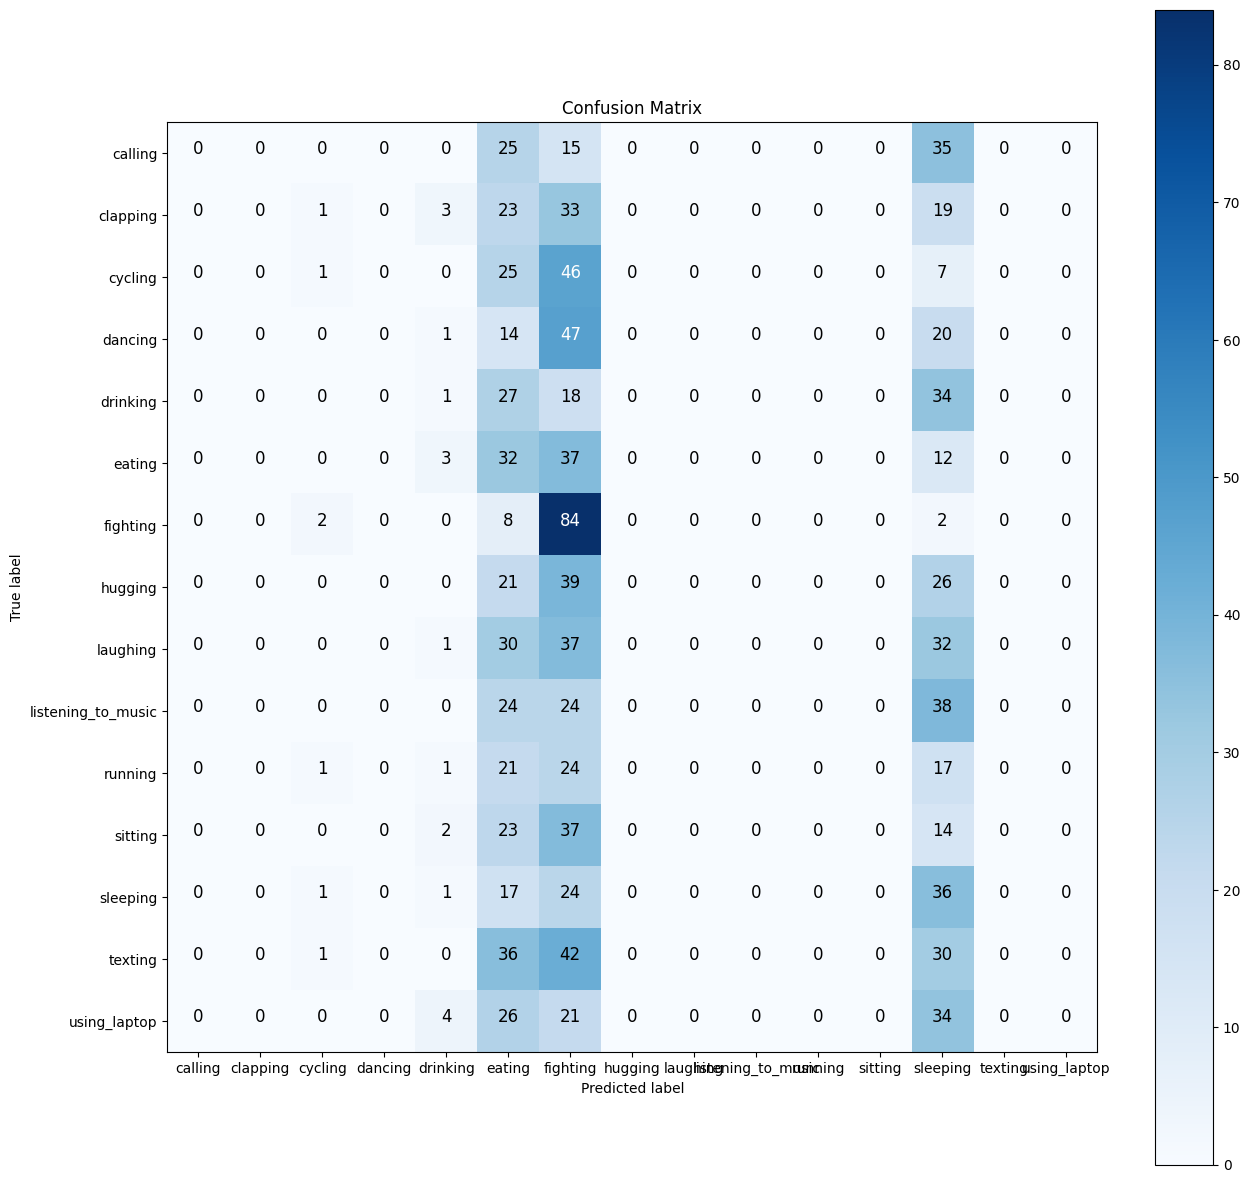

In [36]:
make_confusion_matrix(y_true=labels,
                      y_pred=nn_data_aug_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

As we can see the basic neural network that has to deal with images with such high resolution performs slightly better than guessing which isn't the performance we are looking for, so let's see how the convolutional neural network performs against default neural network.

### Convolutional Neural Network
Last hand-written model will be a simple CNN that will utilize some practices against overfitting such as kernel regularizers on Dense layers, Dropout layers after Dense layers, BatchNormalization layers after each Conv2D layer and an experiment with LeakuReLU activation function (it performed better than ReLU on small scale experiments on our dataset)

We will also use SGD optimizer function with custom parameters to further reduce overfitting and safely descent on the gradient.

In [39]:
input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)
x = Rescaling(1./255)(inputs)
x = Conv2D(64, 7, 2, 
           activation=None, 
           input_shape=input_shape, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, 
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(256, 3, 
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(512, 3,
           padding="same",
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(1024, 3, 
           padding="same",
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, 
          activation="leaky_relu", 
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(256, 
          activation="leaky_relu", 
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
                metrics=["accuracy"])

In [40]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 109, 109, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 64)       0         
 )                                                         

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min', 
                                                  patience=5, 
                                                  restore_best_weights=True,
                                                  start_from_epoch=30)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/HAR/model_1_checkpoint",
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

history_1 = model_1.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                        epochs=100,
                        validation_data=val_ds,
                        validation_steps=len(val_ds),
                        callbacks=[early_stopping,
                                   checkpoint_callback])

Epoch 1/100
178/178 [==============================] - 30s 116ms/step - loss: 31.5450 - accuracy: 0.1372 - val_loss: 29.3801 - val_accuracy: 0.1278
Epoch 2/100
178/178 [==============================] - 19s 107ms/step - loss: 27.4172 - accuracy: 0.1884 - val_loss: 25.6325 - val_accuracy: 0.2127
Epoch 3/100
178/178 [==============================] - 19s 106ms/step - loss: 24.0064 - accuracy: 0.2212 - val_loss: 22.3931 - val_accuracy: 0.2675
Epoch 4/100
178/178 [==============================] - 19s 108ms/step - loss: 21.0638 - accuracy: 0.2505 - val_loss: 19.6693 - val_accuracy: 0.2976
Epoch 5/100
178/178 [==============================] - 19s 107ms/step - loss: 18.5299 - accuracy: 0.2617 - val_loss: 17.3259 - val_accuracy: 0.2873
Epoch 6/100
178/178 [==============================] - 20s 110ms/step - loss: 16.3220 - accuracy: 0.2784 - val_loss: 15.2750 - val_accuracy: 0.3040
Epoch 7/100
178/178 [==============================] - 20s 111ms/step - loss: 14.4130 - accuracy: 0.2914 - val_l

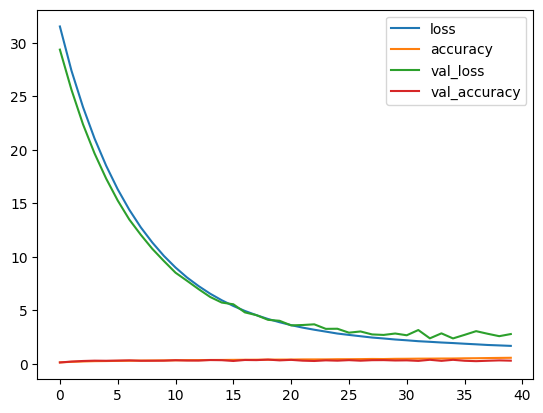

In [ ]:
# Plot loss curve
pd.DataFrame(history_1.history).plot()
plt.legend();

In [ ]:
# Evaluate the model on the weights from last epoch
model_1.evaluate(val_ds)

20/20 [==============================] - 1s 41ms/step - loss: 2.3772 - accuracy: 0.3762


[2.377246618270874, 0.3761904835700989]

In [41]:
# Load the best weights from checkpoint
model_1.load_weights("/content/drive/MyDrive/HAR/model_1_checkpoint")

In [42]:
# Evaluate the model on best weights loaded from checkpoint
cnn_accuracy = model_1.evaluate(val_ds)

20/20 [==============================] - 7s 79ms/step - loss: 4.1157 - accuracy: 0.3952


In [43]:
accuracy_results["cnn"] = cnn_accuracy[1]

In [ ]:
cnn_preds = model_1.predict(val_ds)
cnn_preds = tf.argmax(cnn_preds, axis=1)

20/20 [==============================] - 31s 2s/step


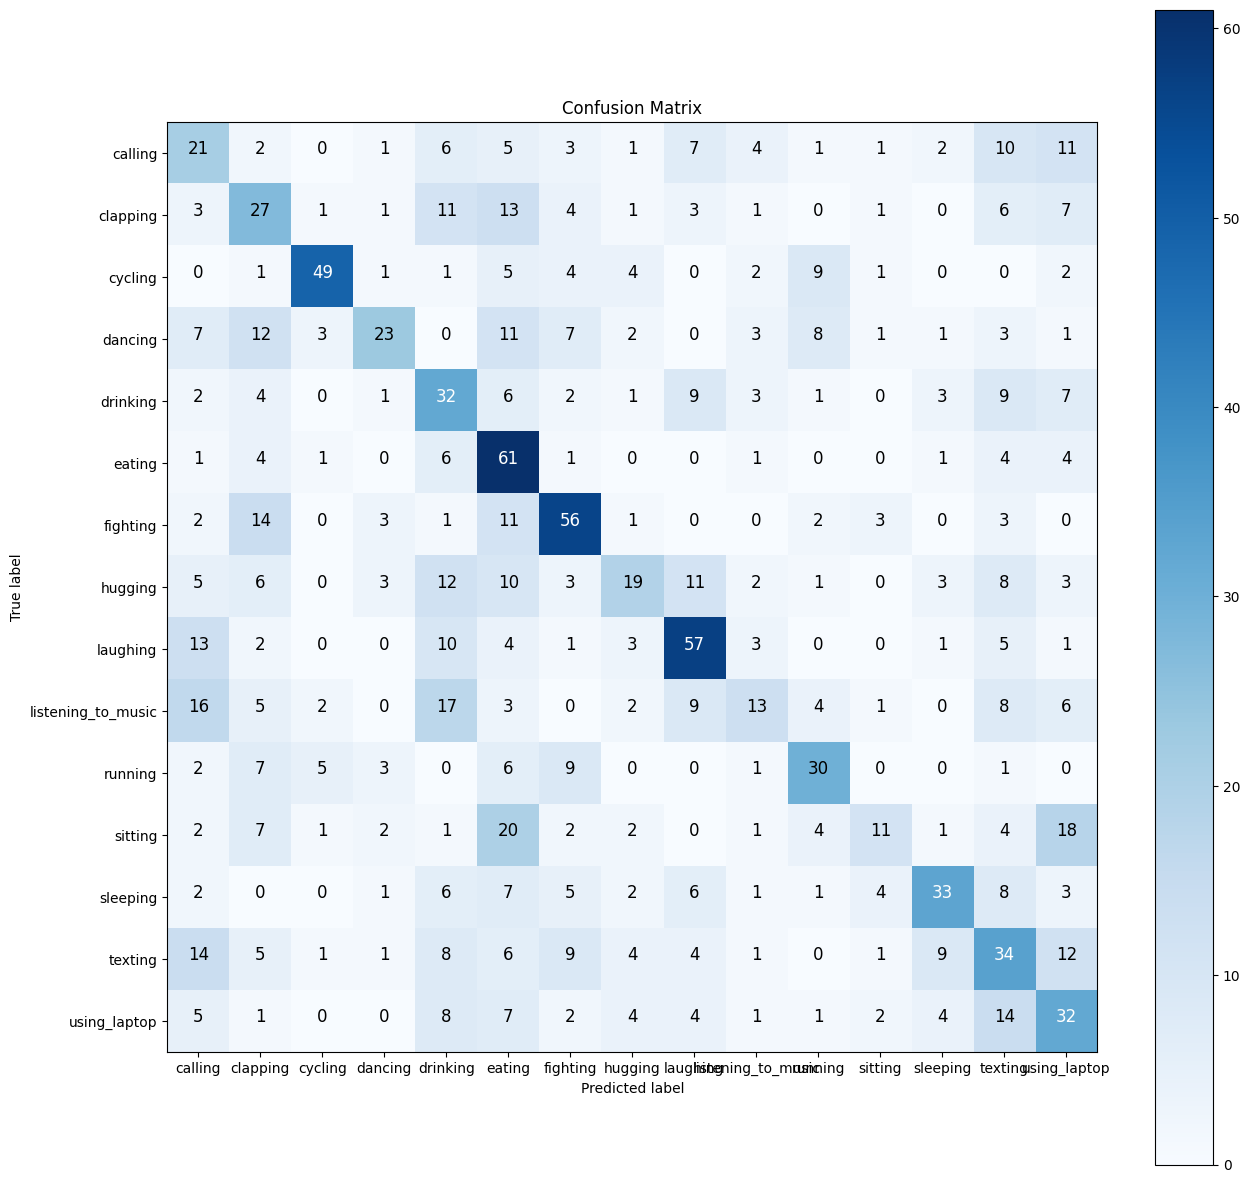

In [ ]:
make_confusion_matrix(y_true=labels,
                      y_pred=cnn_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

Training our CNN model with no data augumentation resulted in huge overfitting and mediocre results on validation dataset.

### Convolutional Neural Network with data augumentation

This one is the same as the one above, but here we will be utilizing data augumentation Sequential layer that was prepared above.

In [44]:
input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)
x = data_augumentation(inputs)
x = Conv2D(64, 7, 2, 
           activation=None, 
           input_shape=input_shape, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, 
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(256, 3, 
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(512, 3,
           padding="same",
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = Conv2D(1024, 3, 
           padding="same",
           activation=None, 
           use_bias=False,
           kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, 
          activation="leaky_relu", 
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(256, 
          activation="leaky_relu", 
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation="softmax")(x)

model_1_data_aug = tf.keras.Model(inputs, outputs)

model_1_data_aug.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
                         metrics=["accuracy"])

In [45]:
model_1_data_aug.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      9408      
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                       

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min', 
                                                  patience=20, 
                                                  restore_best_weights=True,
                                                  start_from_epoch=30)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/HAR/checkpoints",
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

history_1_data_aug = model_1_data_aug.fit(train_ds,
                                          steps_per_epoch=len(train_ds),
                                          epochs=200,
                                          validation_data=val_ds,
                                          validation_steps=len(val_ds),
                                          callbacks=[early_stopping,
                                                     checkpoint_callback])

Epoch 1/200
178/178 [==============================] - 30s 141ms/step - loss: 31.5939 - accuracy: 0.1346 - val_loss: 29.4563 - val_accuracy: 0.1048
Epoch 2/200
178/178 [==============================] - 23s 128ms/step - loss: 27.5053 - accuracy: 0.1694 - val_loss: 25.6679 - val_accuracy: 0.1833
Epoch 3/200
178/178 [==============================] - 26s 141ms/step - loss: 24.1143 - accuracy: 0.1881 - val_loss: 22.4884 - val_accuracy: 0.2325
Epoch 4/200
178/178 [==============================] - 24s 131ms/step - loss: 21.1826 - accuracy: 0.2078 - val_loss: 19.7879 - val_accuracy: 0.2341
Epoch 5/200
178/178 [==============================] - 24s 127ms/step - loss: 18.6529 - accuracy: 0.2235 - val_loss: 17.4032 - val_accuracy: 0.2722
Epoch 6/200
178/178 [==============================] - 23s 124ms/step - loss: 16.4586 - accuracy: 0.2351 - val_loss: 15.3660 - val_accuracy: 0.2714
Epoch 7/200
178/178 [==============================] - 24s 130ms/step - loss: 14.5558 - accuracy: 0.2415 - val_l

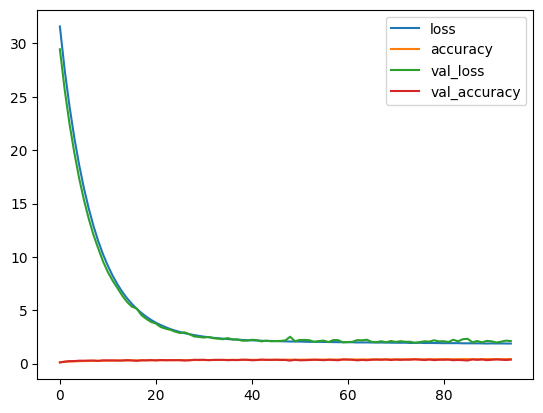

In [ ]:
# Plot loss curve
pd.DataFrame(history_1_data_aug.history).plot()
plt.legend();

In [ ]:
model_1_data_aug.evaluate(val_ds)

20/20 [==============================] - 2s 75ms/step - loss: 1.9499 - accuracy: 0.3992


[1.949912190437317, 0.39920634031295776]

In [46]:
model_1_data_aug.load_weights("/content/drive/MyDrive/HAR/checkpoints")

In [47]:
cnn_data_aug_accuracy = model_1_data_aug.evaluate(val_ds)

20/20 [==============================] - 1s 49ms/step - loss: 1.9499 - accuracy: 0.3992


In [48]:
accuracy_results["cnn_data_aug"] = cnn_data_aug_accuracy[1]

In [ ]:
cnn_data_aug_preds = model_1_data_aug.predict(val_ds)
cnn_data_aug_preds = tf.argmax(cnn_data_aug_preds, axis=1)

20/20 [==============================] - 30s 2s/step


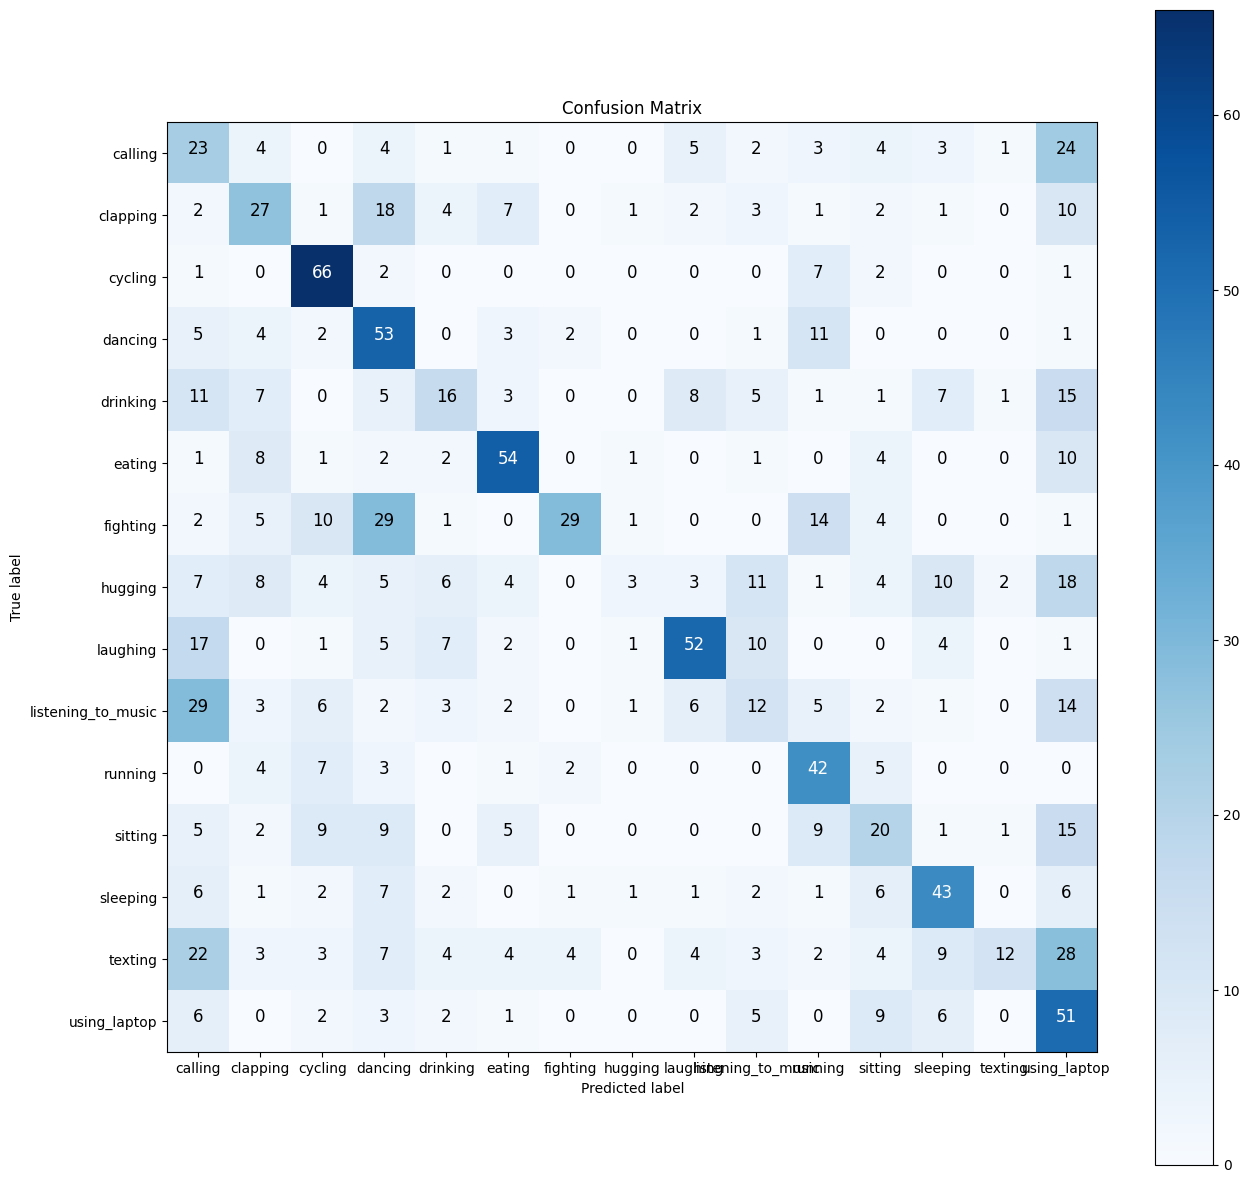

In [ ]:
make_confusion_matrix(y_true=labels,
                      y_pred=cnn_data_aug_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

In [ ]:
model_1_data_aug.save("/content/drive/MyDrive/HAR/model_1_data_aug")

Here we can see that the model overfits again, but not to the same extent as the CNN model with no data augumentation.
Thanks to the data augumentation we were able to get better results on validation dataset.

### Visualize random predictions on CNN data augumentation model

1/1 [==============================] - 0s 62ms/step


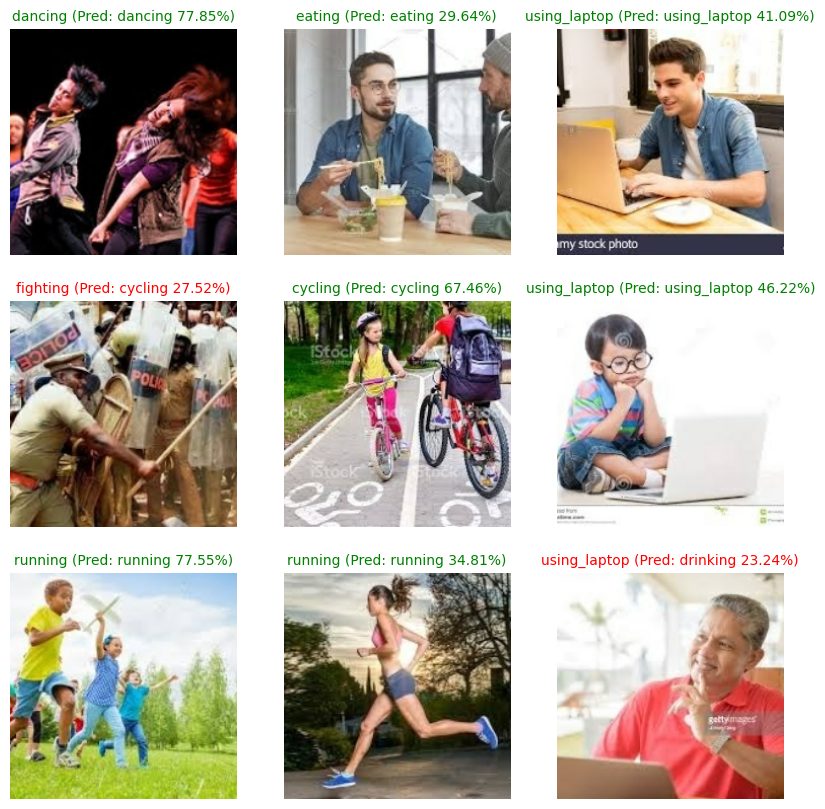

In [ ]:
val_ds = val_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    preds = tf.squeeze(model_1_data_aug.predict(tf.expand_dims(images[i], axis=0)));
    pred_classname = class_names[int(tf.argmax(preds))]
    pred_percentage = tf.reduce_max(preds) * 100

    true_classname_idx = labels[i]
    true_classname = class_names[true_classname_idx]
    plt.imshow(images[i] / 255.);

    if pred_classname == true_classname:
      c = "g"
    else:
      c = "r"

    plt.title(f"{true_classname} (Pred: {pred_classname} {pred_percentage:.2f}%)", color=c, fontsize=10)
    plt.axis("off")

### Feature extraction

In this section we will perform a comparison between our best hand-written CNN against a feature extractor model.

We will use EfficientNetB0 model with data augumentation.

For this purpose we will use input shape of 224x224

In [50]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  input_shape=(224, 224, 3))
base_model.trainable = False

inputs = Input(shape=input_shape)
# x = data_augumentation(inputs)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, 
          activation="leaky_relu", 
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(256, 
          activation="leaky_relu", 
          kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation="softmax")(x)

model_2_feature_extraction = tf.keras.Model(inputs, outputs)

model_2_feature_extraction.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                   optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
                                   metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [51]:
model_2_feature_extraction.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 512)               655872    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                           

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min', 
                                                  patience=5, 
                                                  restore_best_weights=True,
                                                  start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/HAR/model_2_feature_extraction_checkpoint",
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

history_2_feature_extraction = model_2_feature_extraction.fit(train_ds,
                                                              steps_per_epoch=len(train_ds),
                                                              epochs=100,
                                                              validation_data=val_ds,
                                                              validation_steps=len(val_ds),
                                                              callbacks=[early_stopping,
                                                                         checkpoint_callback])

Epoch 1/100
178/178 [==============================] - 38s 164ms/step - loss: 31.2692 - accuracy: 0.2222 - val_loss: 28.6380 - val_accuracy: 0.5294
Epoch 2/100
178/178 [==============================] - 26s 144ms/step - loss: 26.8023 - accuracy: 0.4370 - val_loss: 24.7472 - val_accuracy: 0.5952
Epoch 3/100
178/178 [==============================] - 26s 142ms/step - loss: 23.2581 - accuracy: 0.5208 - val_loss: 21.5182 - val_accuracy: 0.6349
Epoch 4/100
178/178 [==============================] - 26s 142ms/step - loss: 20.2640 - accuracy: 0.5671 - val_loss: 18.7742 - val_accuracy: 0.6587
Epoch 5/100
178/178 [==============================] - 25s 140ms/step - loss: 17.7052 - accuracy: 0.5964 - val_loss: 16.4143 - val_accuracy: 0.6778
Epoch 6/100
178/178 [==============================] - 26s 146ms/step - loss: 15.5086 - accuracy: 0.6081 - val_loss: 14.3813 - val_accuracy: 0.6817
Epoch 7/100
178/178 [==============================] - 27s 148ms/step - loss: 13.6063 - accuracy: 0.6257 - val_l

In [ ]:
model_2_feature_extraction.evaluate(val_ds)

20/20 [==============================] - 3s 120ms/step - loss: 1.1955 - accuracy: 0.7437


[1.1955255270004272, 0.7436507940292358]

In [52]:
model_2_feature_extraction.load_weights("/content/drive/MyDrive/HAR/model_2_feature_extraction_checkpoint")

In [53]:
efficient_net_b0_accuracy = model_2_feature_extraction.evaluate(val_ds)
accuracy_results["efficient_net_b0"] = efficient_net_b0_accuracy[1]

20/20 [==============================] - 6s 154ms/step - loss: 1.2065 - accuracy: 0.7484


In [ ]:
efficient_net_b0_preds = model_2_feature_extraction.predict(val_ds)
efficient_net_b0_preds = tf.argmax(efficient_net_b0_preds, axis=1)

20/20 [==============================] - 65s 3s/step


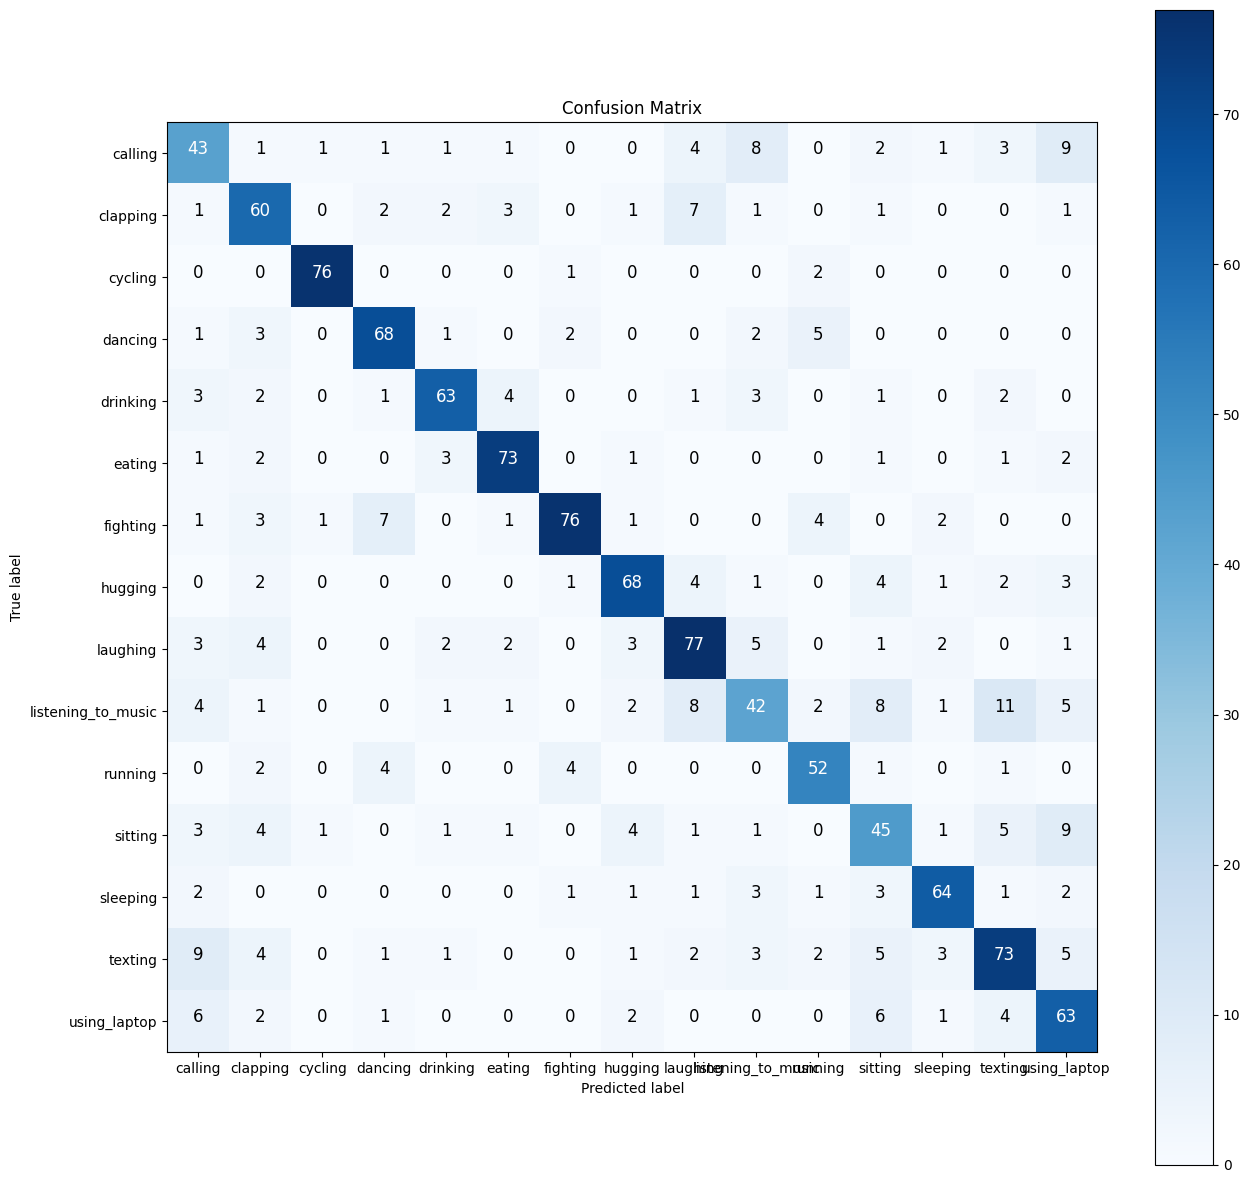

In [ ]:
make_confusion_matrix(y_true=labels,
                      y_pred=efficient_net_b0_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=12)

### Visualizing random predictions on feature extraction model

1/1 [==============================] - 0s 92ms/step


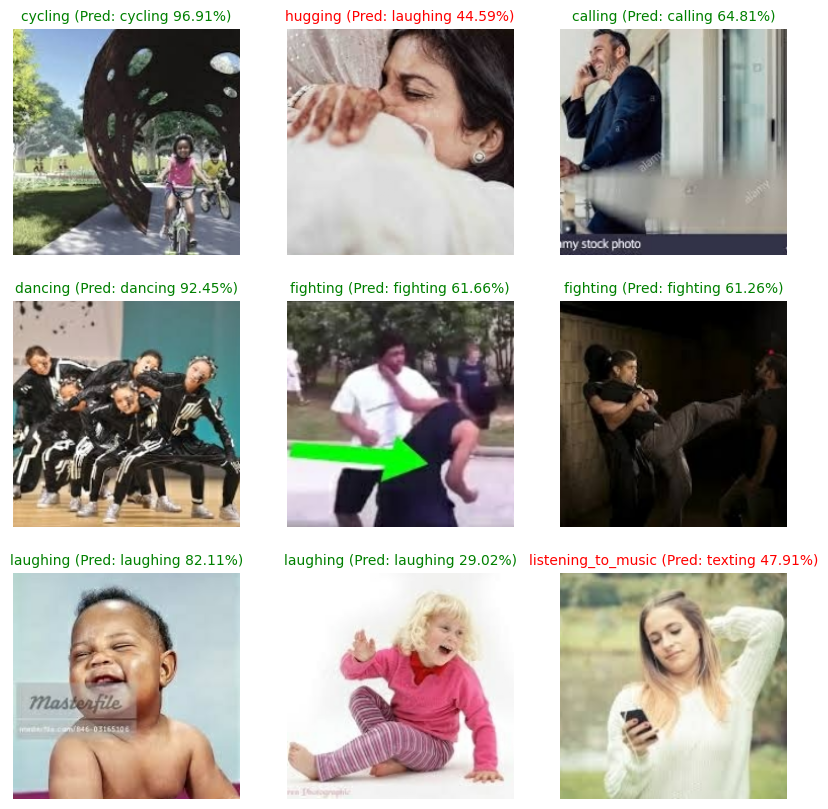

In [ ]:
val_ds = val_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    preds = tf.squeeze(model_2_feature_extraction.predict(tf.expand_dims(images[i], axis=0)));
    pred_classname = class_names[int(tf.argmax(preds))]
    pred_percentage = tf.reduce_max(preds) * 100

    true_classname_idx = labels[i]
    true_classname = class_names[true_classname_idx]
    plt.imshow(images[i] / 255.);

    if pred_classname == true_classname:
      c = "g"
    else:
      c = "r"

    plt.title(f"{true_classname} (Pred: {pred_classname} {pred_percentage:.2f}%)", color=c, fontsize=10)
    plt.axis("off")

# Accuracy results comparison

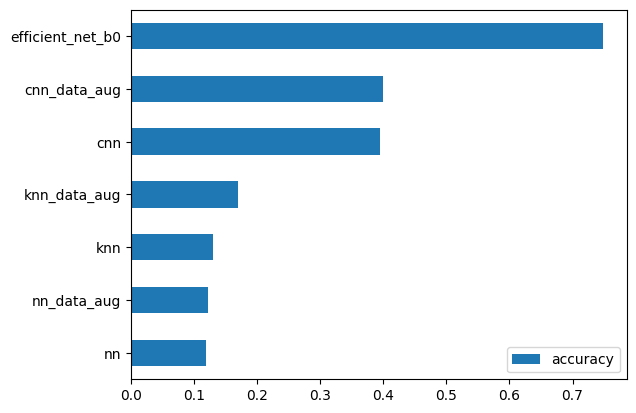

In [54]:
results_df = pd.DataFrame(accuracy_results,
                          columns=list(accuracy_results.keys()),
                          index=["accuracy"])

results_df.T.sort_values(by="accuracy", ascending=True).plot.barh();

# Summary

According to the results of our experiments we didn't hit our evaluation metric of **85%** accuracy on validation dataset. However the closest one was the EfficientNetB0 model which was actually used as a reference to our hand-written models.

As we can see from the results of our experiments, standard Neural Networks do not work well with image data (probably due to enormous amount of parameters - in our case it was 20 million parameters).

On contrary, the K-Nearest Neighbours model performed a little bit better, but the scikit-learn implementation requires the data to be in format of numpy ndarray or pandas DataFrame, which in comparison with TensorFlow Dataset format takes way more space in memory (due to that we had to lower the images resolution to 112x112x3 because each time I tried to load 12 thousand 224x224x3 images I ran out of memory).

The best one turned out to be a Convolutional Neural Network (no surprise) which actually performed quite fine on our evaluation dataset despite of the fact that the architecture is not that complicated and we had around 7 million parameters available for learning. Around 40% accuracy on validation dataset with 15 classes on a hand-written model that was trained on ~11 thousand images is a decent score in my opinion.

The model that we used for comparison is the smallest EfficientNet model, that has around 4 million parameters. We didn't use fine tuning, but we added some Dense layers at the end and still we were able to obtain ~75% accuracy on validation dataset. This fact implies that if we used bigger model with more learning parameters or even the same model, but with fine-tuning, we could obtain significantly better results.